# Running NN on the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sknn.mlp import Classifier, Layer
from sklearn.metrics import confusion_matrix
from pcfm import plot_confusion_matrix
from pfimp import plot_feature_importance
from sklearn.model_selection import StratifiedKFold
from threeinone import cfm3in1, fimp3in1
from fpr_area import givemis,areas,erts_plot,thres

/home/shining/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('all_in_one.csv')
df = pd.DataFrame.as_matrix(df)
# It seems there are NaNs in the dataset.. 
# And all of them are in column 3. The one with log(.)
df = df[~np.isnan(df).any(axis=1)]
X = df[:,0:6] # Our feature matrix
y = np.array(df[:,-1],dtype=np.int) # Our truth labels
idx = np.array(df[:,6],dtype=np.int) # our ID
clname = ['RFI','PULSAR']
np.set_printoptions(precision=2)
# Mean centering
X -= X.mean(0)

In [25]:
np.unique(y,return_counts=True)

(array([0, 1]), array([87680,  1192]))

## No oversampling

In [18]:
kf = StratifiedKFold(3,shuffle=True,random_state=340)
conf_mats = [] # list to hold the confusion matrices
predprobs = [] # predicted probabilities

In [19]:
# Hyperparameters
smnnlayer = [Layer("Rectifier",units=6,weight_decay=1e-6),Layer("Rectifier",units=4,weight_decay=1e-3,dropout=.3)]
smnnlayer.append(Layer('Softmax'))
nnlayer = [Layer("Rectifier",units=8,weight_decay=1e-3,dropout=.4)]
nnlayer.append(Layer('Softmax'))
k_fold = 3

In [20]:
rc = 0
plt.figure()
for tr,te in kf.split(X,y):
     print "[",rc,'] Iteration...Starting'
     xtrain, xtest = X[tr],X[te]
     ytrain, ytest = y[tr],y[te]
     nn = Classifier(layers=nnlayer,learning_rule='adam',batch_size=256,valid_size=0.2,random_state=1234)
     print "[``] Fitting"
     nn.fit(xtrain,ytrain) # My fitting
     ypredict = nn.predict(xtest)
     conf_mats.append(confusion_matrix(ytest,ypredict))
     ypp = nn.predict_proba(xtest)
     tdf = np.column_stack((ytest,ypredict,ypp[:,0],ypp[:,1]))
     if rc == 0:
        outdf = tdf
     else:
        outdf = np.concatenate((outdf,tdf),axis=0)
     print "[",rc,'] Iteration...Done'
     rc = rc + 1

[ 0 ] Iteration...Starting
[``] Fitting
[(29625, 2)]
[(29625, 2)]
[ 0 ] Iteration...Done
[ 1 ] Iteration...Starting
[``] Fitting
[(29624, 2)]
[(29624, 2)]
[ 1 ] Iteration...Done
[ 2 ] Iteration...Starting
[``] Fitting
[(29623, 2)]
[(29623, 2)]
[ 2 ] Iteration...Done


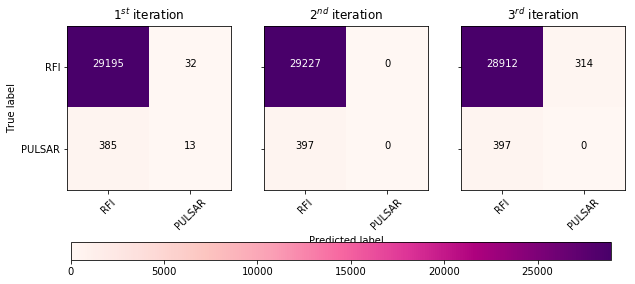

In [21]:
cfm3in1(conf_mats,clname)
plt.show()

## SMOTE
SMOTE is a way to learn imbalanced or highly skewed datasets. 
We specify a ratio of minority samples(pulsars) and majority samples(RFIs) and SMOTE using K-means and interpolation, generates new samples of the minority class until the desired ratio is achieved. 

After getting sX,sy afterever follows is the same. Fitting and plotting just with a minor change that I've prepended 'sm' to each variable to differentiate.

In [7]:
from imblearn.over_sampling import SMOTE
# this is one additional function I'll be needing
sme = SMOTE(ratio=0.5,random_state=1234) # please refer the above section for param definitions.
smX,smy = sme.fit_sample(X,y) # transforming 

In [26]:
np.unique(smy,return_counts=True)

(array([0, 1]), array([87680, 43840]))

In [8]:
smkf = StratifiedKFold(3,shuffle=True,random_state=340)
smconf_mats = [] # list to hold the confusion matrices
smpredprobs = [] # predicted probabilities

In [9]:
rc = 0
plt.figure()
for tr,te in kf.split(smX,smy):
     print "[",rc,'] Iteration...Starting'
     xtrain, xtest = smX[tr],smX[te]
     ytrain, ytest = smy[tr],smy[te]
     nn = Classifier(layers=smnnlayer,learning_rule='adam',batch_size=500,valid_size=0.2,random_state=1234)
     print "[``] Fitting"
     nn.fit(xtrain,ytrain) # My fitting
     ypredict = nn.predict(xtest)
     smconf_mats.append(confusion_matrix(ytest,ypredict))
     ypp = nn.predict_proba(xtest)
     tdf = np.column_stack((ytest,ypredict,ypp[:,0],ypp[:,1]))
     if rc == 0:
        smoutdf = tdf
     else:
        smoutdf = np.concatenate((smoutdf,tdf),axis=0)
     print "[",rc,'] Iteration...Done'
     rc = rc + 1

[ 0 ] Iteration...Starting
[``] Fitting
[(43841, 2)]
[(43841, 2)]
[ 0 ] Iteration...Done
[ 1 ] Iteration...Starting
[``] Fitting
[(43840, 2)]
[(43840, 2)]
[ 1 ] Iteration...Done
[ 2 ] Iteration...Starting
[``] Fitting
[(43839, 2)]
[(43839, 2)]
[ 2 ] Iteration...Done


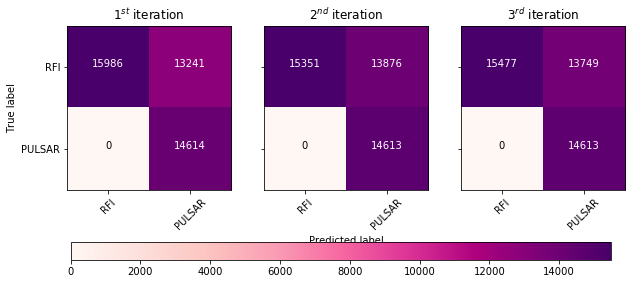

In [10]:
cfm3in1(smconf_mats,clname)
plt.show()

## FPR Analysis

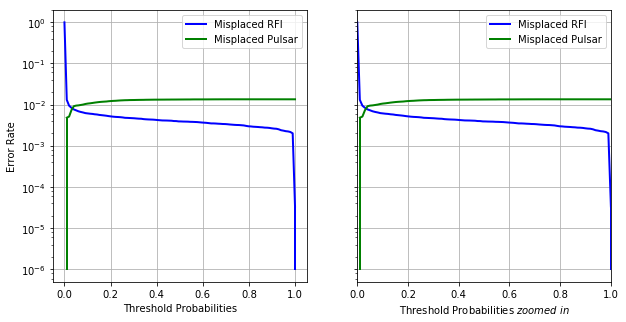

In [23]:
erts_plot(givemis(outdf,0.0,1.0),givemis(outdf,0.0,1.0),[0.0,1.0])
plt.show()

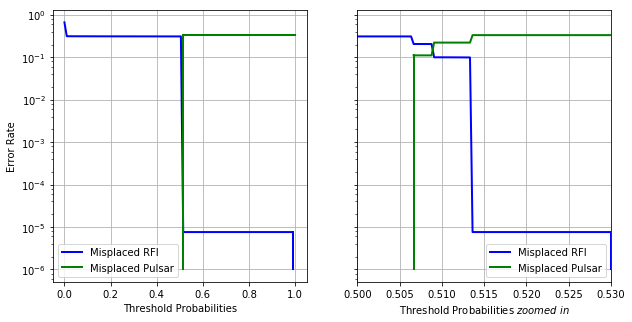

In [24]:
erts_plot(givemis(smoutdf,0.0,1.0),givemis(smoutdf,0.5,0.53),[0.5,0.53])
plt.show()

In [35]:
thres(0.2,outdf)

FPR: 0.00517598343685
FNR: 0.0121635610766
Recall: 0.0931208053691
Precision: 0.194395796848


In [36]:
thres(0.6,outdf)

FPR: 0.00365694481952
FNR: 0.0133450355568
Recall: 0.00503355704698
Precision: 0.0181268882175


In [37]:
thres(0.9,outdf)

FPR: 0.00265550454586
FNR: 0.0134125483842
Recall: 0.0
Precision: 0.0


In [38]:
thres(0.507,smoutdf)

FPR: 0.205953467153
FNR: 0.111108576642
Recall: 0.666674270073
Precision: 0.519000603758


In [42]:
thres(0.510,smoutdf)

FPR: 0.0999923965937
FNR: 0.222217153285
Recall: 0.333348540146
Precision: 0.526346119215


In [41]:
thres(0.512,smoutdf)

FPR: 0.09962743309
FNR: 0.222217153285
Recall: 0.333348540146
Precision: 0.527257639716


## Metric scores

In [27]:
from sklearn.metrics import *

In [28]:
print "The recall score is    {:0.4f}".format(recall_score(outdf[:,0],outdf[:,1]))
print "The precision score is {:0.4f}".format(precision_score(outdf[:,0],outdf[:,1]))
print "The accuracy is        {:0.4f}".format(accuracy_score(outdf[:,0],outdf[:,1]))
print "The f1 score is        {:0.4f}".format(f1_score(outdf[:,0],outdf[:,1]))
print "The logloss score is   {:0.4f}".format(log_loss(outdf[:,0],outdf[:,1]))
print "The MCC is             {:0.4f}".format(matthews_corrcoef(outdf[:,0],outdf[:,1]))

The recall score is    0.0109
The precision score is 0.0362
The accuracy is        0.9828
The f1 score is        0.0168
The logloss score is   0.5927
The MCC is             0.0126


In [29]:
print "The recall score is    {:f}".format(recall_score(smoutdf[:,0],smoutdf[:,1]))
print "The precision score is {:0.4f}".format(precision_score(smoutdf[:,0],smoutdf[:,1]))
print "The accuracy is        {:0.4f}".format(accuracy_score(smoutdf[:,0],smoutdf[:,1]))
print "The f1 score is        {:0.4f}".format(f1_score(smoutdf[:,0],smoutdf[:,1]))
print "The logloss score is   {:0.4f}".format(log_loss(smoutdf[:,0],smoutdf[:,1]))
print "The MCC is             {:0.4f}".format(matthews_corrcoef(smoutdf[:,0],smoutdf[:,1]))

The recall score is    1.000000
The precision score is 0.5176
The accuracy is        0.6893
The f1 score is        0.6821
The logloss score is   10.7322
The MCC is             0.5257


## Area analysis

In [30]:
areas(givemis(outdf,0.0,1.0))

mmint 0.00407323603606
mis1 0.00836928902855
mis2 0.0125268782129


In [31]:
areas(givemis(smoutdf,0.0,1.0))

mmint 3.69290021054e-06
mis1 0.160616742496
mis2 0.1632996633
